# pset07: Wiggins' lost labels
*by Xingyu (Luna) Li , Oct 18th, 2021*
  
## Background
Wiggins' characterized the mutation's effect on overall gene expression in RNA-seq experiments of sandmouse.  
He did two sets of three replicates on wild type control mice, and one set of three replicates on his mutant sand mice. But unfortunately, he mislabeled the files and lost track of which was which.
And his notebook says he identified 2107 differentially expressed genes significant at P<0.05.
  
## 1. Write a python function to run an external edgeR analysis
Since Wiggins' analysis pipeline used the well-regarded edgeR package for differential gene expression analysis, I am going to write a python function that takes the name of an input counts file as an argument, and returns the results of an edgeR analysis: gene names, log fold changes, log CPM, P-values, and FDRs.

In [1]:
import os
import pandas as pd

# Define the function
def edgeR(file):
    os.rename(file, "mydata.tbl")    # rename the file so it can be read by the R script
    ! Rscript analyze_W.r   # use Wiggins' R script to analyze the data
    result = pd.read_table('myresult.out', sep = " ", header=0) # read the output file
    return result

## 2. Reproduce Wiggins' data, assign the missing labels

Next, we want to use all of the three possible combinations of Wiggins' data files to perform the edgeR differential gene expression analysis (DGEA).


In [2]:
# Create the combinations of the three files
! join -t $'\t' w07-data.1 w07-data.2 > merged.12
! join -t $'\t' w07-data.1 w07-data.3 > merged.13
! join -t $'\t' w07-data.2 w07-data.3 > merged.23

# Perform the edgeR analysis
result12 = edgeR("merged.12")
result13 = edgeR("merged.13")
result23 = edgeR("merged.23")

# Return the number of significant genes (P<0.05)
n12 = len(result12[result12['PValue']<0.05])
n13 = len(result13[result13['PValue']<0.05])
n23 = len(result23[result23['PValue']<0.05])
print("There are {}, {} and {} differentially expressed genes significant at P < 0.05 for each combinations of the data respectively.".format(n12,n13,n23))

Loading required package: limma
Using classic mode.
Loading required package: limma
Using classic mode.
Loading required package: limma
Using classic mode.
There are 2107, 1978 and 1018 differentially expressed genes significant at P < 0.05 for each combinations of the data respectively.


Now we can see that the combination that Wiggins' used to obtain his result of 2107 differentially expressed genes is the **first and second dataset**.    

We can also infer from the results that the first dataset is from the mutant sand mouse samples, since combination of the second and third dataset gives the lowest total significant counts, indicating that they are more similar to each other than the first dataset. 

We could draw a multidimensional scaling (MDS) plot to verify our conclusion：

Loading required package: limma
Note: the bcv method is now scheduled to be removed in a future release of edgeR.
null device 
          1 


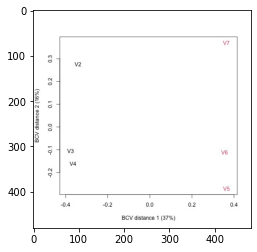

Loading required package: limma
Note: the bcv method is now scheduled to be removed in a future release of edgeR.
null device 
          1 


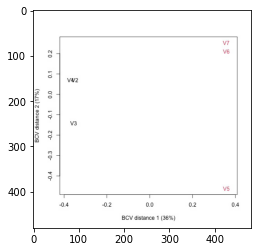

Loading required package: limma
Note: the bcv method is now scheduled to be removed in a future release of edgeR.
null device 
          1 


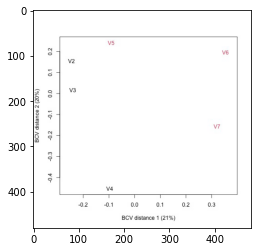

In [3]:
# Write a R script to draw the MDS plot
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
r = open("mds.r", "w")  # open a file called "mds.r" to write
r.writelines([
    "library(edgeR) \n","infile <- 'mydata.tbl' \n","group <- factor(c(1,1,1,2,2,2)) \n",
    "x <- read.table(infile, sep='\t', row.names=1) \n", "y <- DGEList(counts=x,group=group) \n",
    "y <- calcNormFactors(y) \n", "jpeg(file='mds.jpeg') \n", 
    "plotMDS(y, method='bcv', col=as.numeric(y$samples$group)) \n", # plot MDS
    "dev.off()"])
r.close()

# Define a function to run the script
def mds(file):
    os.rename(file, "mydata.tbl")    # rename the file so it can be read by the R script
    ! Rscript mds.r
    img = mpimg.imread('mds.jpeg')
    imgplot = plt.imshow(img)
    plt.show()
    
# Create the combinations of the three files
! join -t $'\t' w07-data.1 w07-data.2 > merged.12
! join -t $'\t' w07-data.1 w07-data.3 > merged.13
! join -t $'\t' w07-data.2 w07-data.3 > merged.23

# Show the MDS plot
mds("merged.12")
mds("merged.13")
mds("merged.23")

Since MDS is a means of visualizing the level of similarity of samples, those similar would be near to each other in the plot while samples that are dissimilar are far from each other. 

We can confirm that **the first dataset is from the mutant sand mouse samples** and seperate away from the other two wildtype samples.

## 3. Wiggins doesn't understand p-values

However, is Wiggins' conclusion correct?
  
He chose a threshold of p < 0.05 to identify the genes with *significant* expression difference in wildtype and mutant samples. In DGEA, for each gene, a test statistic and its corresponding P-value are calculated to determine the extent of differential expression. The P-value is the probability for the experimental outcome as observed or more extreme, if there is no difference in expression between the experimental conditions. A small P-value indicates evidence of differential expression, either overexpression or underexpression. 
  
However, the significance level of a P-value is ordinarily defined under a single hypothesis. In a large-scale analysis like this, as tens of thousands of tests are conducted, simply using the significance level for a cutoff without adjusting for multiple tests will **increase the chance of false positives**. 

However, simply applying a multiple-test adjustment procedure often results in a short list of significant genes because of large variability inherent in RNA-seq experiments and small sample sizes. Criteria for the level of significance should depend on our objective of the experiment. In this task, our objective is to identify a small number of truly differentially expressed genes, then a stringent criterion such as controlling the false discovery error rate may be appropriate. 
   
A **False Discovery Rate (FDR)** is a common error measures for choosing a significant cutoff in multiple testing, which considers the probability of false selections among the selected genes. It emphasizes the false-positive error in determining the cutoff threshold. When the experimental objective is to develop genetic profiles, many genes that are involved in the complex functional relationship with other genes might merely have moderate differential expressions between experimental conditions. Because of small sample sizes and an effort to maintain a low significance level, an FDR approach would give us a short significant list. 

In [4]:
# Return the number of significant genes (FDR<0.05)
n12f = len(result12[result12['FDR']<0.05])
n13f = len(result13[result13['FDR']<0.05])
n23f = len(result23[result23['FDR']<0.05])
print("There are {}, {} and {} differentially expressed genes significant at FDR < 0.05 for each combinations of the data respectively.".format(n12f,n13f,n23f))

# Find the genes both significant expressed in 1 vs 2 and 1 vs 3
overlap = set(result12[result12['FDR']<0.05].index).intersection(result13[result13['FDR']<0.05].index)
len(overlap)
print("There are {} genes both differentially expressed in 1 vs 2 and 1 vs 3, they are: \n {}".format(len(overlap),overlap))

There are 63, 63 and 0 differentially expressed genes significant at FDR < 0.05 for each combinations of the data respectively.
There are 52 genes both differentially expressed in 1 vs 2 and 1 vs 3, they are: 
 {'currant', 'fennel', 'kiwi', 'chickpea', 'eggplant', 'watermelon', 'rhubarb', 'peach', 'nectarine', 'ginger', 'lettuce', 'strawberry', 'kohlrabi', 'banana', 'mustard', 'beet', 'plantain', 'papaya', 'rosemary', 'pea', 'thyme', 'coriander', 'arugula', 'cranberry', 'pepper', 'SET', 'chard', 'persimmon', 'blackberry', 'juniper', 'pineapple', 'melon', 'ELP4', 'watercress', 'radish', 'raisin', 'pomegranate', 'horseradish', 'cabbage', 'okra', 'plum', 'elderberry', 'chestnut', 'quince', 'mulberry', 'olive', 'asparagus', 'tomato', 'fig', 'artichoke', 'grape', 'potato'}


Here, **by controlling the FDR at 0.05, we get 63 significant genes in both the 1 & 2 and 1 & 3 combinations**, which means that among all these genes we identified as significant expressed, 5% of these (only 3) are truly no difference in expression of wildtype and mutant samples. Among all those genes, 52 of them are shared by both combinations of wt and mut, indicating that our experiments is quiet robust.
  
These differentially expressed genes so selected are referred as *statistically significant*. However, if an observed change is small and precise, that is, the standard deviation is very small, then the change can be identified as statistically significant even if it may not be *significant biologically*.
  
Therefore, a **volcano plot** is often used, which is a scatter plot of the fold-change versus the P-value (in −log10p scale). It has been used to simultaneously depict the P-value and the fold-change for gene selection cutoff schemes in RNA-seq data. It may be viewed as a summary of ‘statistical’ significance and ‘biological’ significance over a large number of genes.

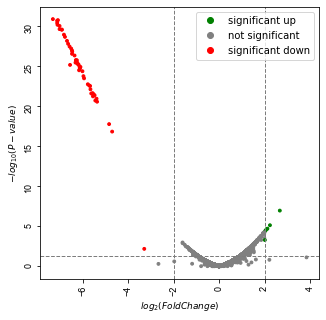

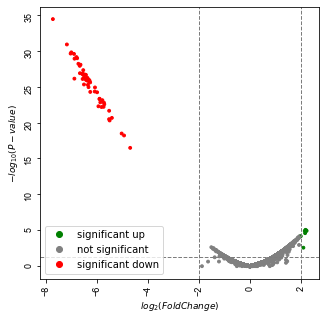

In [5]:
# Draw the volcano plot
# ! pip install bioinfokit
from bioinfokit import analys, visuz
visuz.gene_exp.volcano(result12, lfc='logFC', pv='PValue', lfc_thr = (2.0,2.0), plotlegend=True, sign_line=True, show = True)
visuz.gene_exp.volcano(result13, lfc='logFC', pv='PValue', lfc_thr = (2.0,2.0), plotlegend=True, sign_line=True, show = True)

Here, by drawing a volcano plot using the 0.05 P-value with a twofold change cutoff, genes landing on the upper left region and the upper right region have a small P-value with a large absolute fold-change. We can see that **most of the differentially expressed genes up-regulate in the mutant** (since we are comparing mutant sample data 1 to wildtype sample data 2 & 3, we need to invert the results). 

In conclusion, compared to Wiggins' method, our first approach of using the False Discovery Rate to select differentially expressed genes allows us to decide how many false positives we are willing to accept among all the features that we call significant; our second approach of using the P-value as the primary criterion followed by the fold-change as the secondary criterion provides the control of false-positive error and, in the meantime, preserves the desired biological significance with scientific vigor.

## 4. Wiggins missed something else too

By looking into Wiggins' edgeR analysis pipeline, we find other problems of his analysis.

First, experiments like RNA-seq can generate vast amounts of data, the relative abundances of one gene would be dependent on other genes. Therefore, **normalization** should be included as a critical component of the processing pipeline, allowing accurate estimation and detection of differential expression. 

We are going to implement a method called trimmed mean of M values (TMM) to normalize our RNA-seq data. The assumptions behind the TMM method is that the majority of genes, common to both samples, are not differentially expressed, so we could estimate scale factors between samples that minimize the number of significantly expressed genes.

Second, Wiggins' also forget to **remove genes with low expression**. Those genes with very low map counts probably have a poor sequencing quality and the "0" count number would lead to an error when we take the log of it.

Here, we will set a threshold of 100 cpm (counts per gene per million mapped reads) and only keep genes with a cpm of at least 100 in at least two samples.  

The next step would be to write a fixed R script and re-perform our analysis.

In [6]:
# Write a R script to perform the fixed edgeR analysis
r = open("analyze_fixed.r", "w")  # open a file called "analyze_fixed.r" to write
r.writelines([
    "library(edgeR) \n",
    "infile <- 'mydata.tbl' \n","group <- factor(c(1,1,1,2,2,2)) \n", "outfile <- 'myresult.out' \n",
    "x <- read.delim(infile, row.names=1) \n", 
    "y <- DGEList(counts=x,group=group) \n",
    "keep <- rowSums(cpm(y)>=100)>=2 \n", "y <- y[keep,] \n" # only keep rows with at least 100 counts
    "y <- calcNormFactors(y) \n",   # add a TMM normalization step
    "y <- estimateDisp(y) \n", 
    "et <- exactTest(y) \n", 
    "tab <- topTags(et, nrow(x)) \n",
    "write.table(tab, file=outfile)"
])
r.close()

# Define the function to run the fixed R script
def edgeR_fixed(file):
    os.rename(file, "mydata.tbl")    # rename the file so it can be read by the R script
    ! Rscript analyze_fixed.r   # use Wiggins' R script to analyze the data
    result = pd.read_table('myresult.out', sep = " ", header=0) # read the output file
    return result

Loading required package: limma
Using classic mode.
Loading required package: limma
Using classic mode.
There are 50 and 50 differentially expressed genes significant at FDR < 0.05 for each combinations of the data respectively.
There are 49 genes both differentially expressed in 1 vs 2 and 1 vs 3, they are: 
 {'currant', 'fennel', 'kiwi', 'chickpea', 'eggplant', 'watermelon', 'rhubarb', 'peach', 'nectarine', 'lettuce', 'ginger', 'strawberry', 'kohlrabi', 'banana', 'mustard', 'beet', 'plantain', 'papaya', 'rosemary', 'pea', 'thyme', 'coriander', 'arugula', 'pepper', 'chard', 'persimmon', 'blackberry', 'juniper', 'pineapple', 'melon', 'watercress', 'radish', 'raisin', 'pomegranate', 'horseradish', 'cabbage', 'okra', 'plum', 'elderberry', 'quince', 'chestnut', 'mulberry', 'olive', 'asparagus', 'tomato', 'fig', 'artichoke', 'grape', 'potato'}


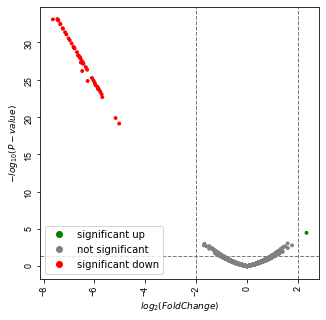

In [7]:
# Create the combinations of the three files
! join -t $'\t' w07-data.1 w07-data.2 > merged.12
! join -t $'\t' w07-data.1 w07-data.3 > merged.13

# Perform the edgeR analysis
result12 = edgeR_fixed("merged.12")
result13 = edgeR_fixed("merged.13")

# Return the number of significant genes (FDR<0.05)
n12f = len(result12[result12['FDR']<0.05])
n13f = len(result13[result13['FDR']<0.05])
print("There are {} and {} differentially expressed genes significant at FDR < 0.05 for each combinations of the data respectively.".format(n12f,n13f))

# Find the genes both significant expressed in 1 vs 2 and 1 vs 3
overlap = set(result12[result12['FDR']<0.05].index).intersection(result13[result13['FDR']<0.05].index)
len(overlap)
print("There are {} genes both differentially expressed in 1 vs 2 and 1 vs 3, they are: \n {}".format(len(overlap),overlap))

# Draw the volcano plot
# ! pip install bioinfokit
from bioinfokit import analys, visuz
visuz.gene_exp.volcano(result12, lfc='logFC', pv='PValue', lfc_thr = (2.0,2.0), plotlegend=True, sign_line=True, show = True)

After the normalization and removal of low expression genes, we get a more accurate result of 50 significant genes in each combination respectively, and 49 genes both expressed differentially in our data combinations of wildtype and mutant sandmouse. Notably, those genes all have a higher expression level in the mutant samples.